# Regression modelling

In this notebook we consider several regression models:
1. Linear regression using only time features (hour, month, holiday)
2. Linear regression using weather and time features (hour, month, holiday)
3. Linear regression with polynomial features on current measured weather
4. Use previously trained linear regression model in 3. to forecast the next 24h of net energy usage using 24h weather predictions

Finally, we will do some feature engineering by categorizing the hour into time of the day (morning, afternoon, evening, night) and months into seasons (spring, summer, autumn, winter).

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

from green_city.regression import plot_ts, error_metrics, train_test_time_split
from green_city.utils import span, index2datetime
from green_city.plotting import plot_decomposition
from green_city.mlflow_config import get_mlflow_config

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [2]:
building_nr = 5
column_to_predict = "net_load_kW"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building nr": building_nr,
    "predicted feature": column_to_predict,
    "resolution": "daily",
}

In [3]:
# Set write_date to True for logging to mlflow and SQL database
write_data = False

if write_data:
    
    # ## MLFLOW ##
    try:
        import mlflow
        from green_city.mlflow_config import get_mlflow_config

        flow_conf = get_mlflow_config()
        tracking_uri = flow_conf["TRACKING_URI"]
        mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
        mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    except:
        print("mlflow ui not active")


    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))
    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)

### Load data

In [4]:
# Load data
df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [5]:
# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

# Extra columns for time features
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year

### Correlation matrix

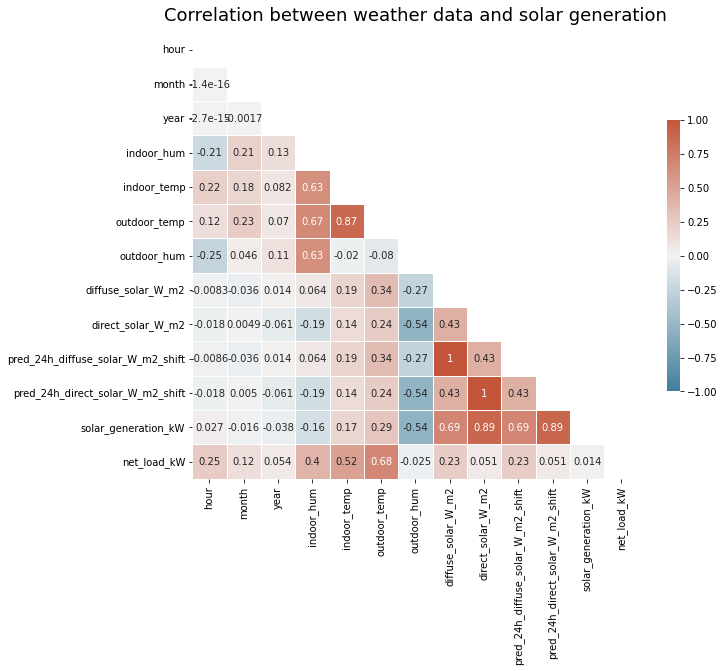

In [6]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
corr_weather= df[['hour', 'month', 'year', 'indoor_hum', 'indoor_temp', 
                    'outdoor_temp','outdoor_hum', 'diffuse_solar_W_m2', 
                    'direct_solar_W_m2', 'pred_24h_diffuse_solar_W_m2_shift', 
                    'pred_24h_direct_solar_W_m2_shift', 'solar_generation_kW',
                    'net_load_kW']].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr_weather, mask=mask, cmap=cmap, vmax=1, vmin=-1, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
heatmap.set_title('Correlation between weather data and solar generation', 
                    fontdict={'fontsize':18}, pad=12);


## Regression modelling

### 1. Multiple linear regression model using time based features

In [7]:
# Define time-based features for linear regression
features = ['hour', 'month', 'year', 'holiday', 'workday']
dummy_features = ['hour', 'month', 'year', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [8]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict for train data
y_pred_train = lin_reg.predict(X_train)
df_train['linreg_time'] = y_pred_train

# Predict for test data
y_pred_test = lin_reg.predict(X_test)
df_test['linreg_time'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression (time features)")

----------------------------------------
Linear regression (time features)
----------------------------------------
R2 (train): 0.66
R2 (test) : 0.518
MAE (test): 6.086
MSE (test): 59.588
RMSE(test): 7.719


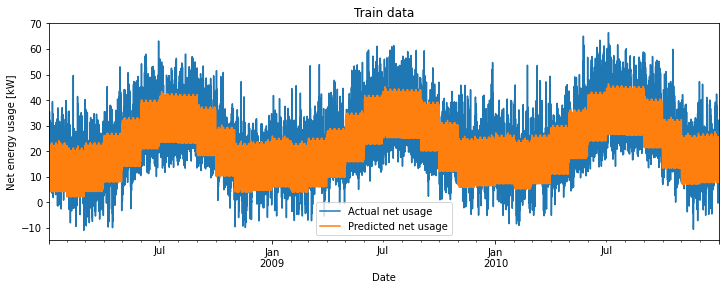

In [17]:
# Plot actual vs predicted train data
plot_ts(df_train['net_load_kW'], df_train['linreg_time'], "Train data")

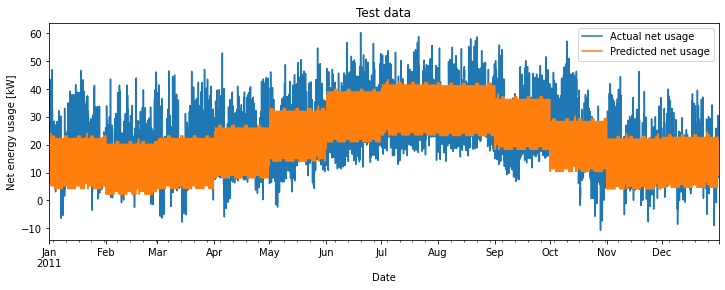

In [38]:
# Plot actual vs predicted test data
plot_ts(df_test['net_load_kW'], df_test['linreg_time'], "Test data")

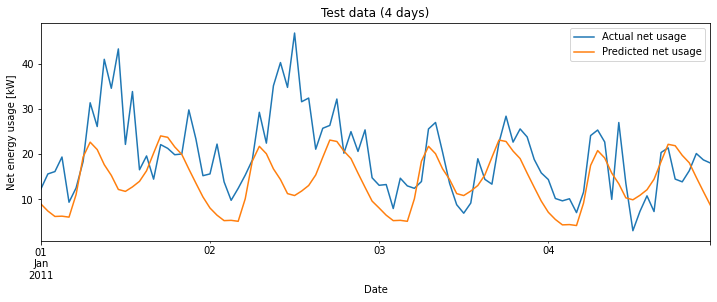

In [39]:
# Plot actual vs predicted test data for 4 days
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['linreg_time'].iloc[0:24*4], "Test data (4 days)")

Day: 2011-09-01 23:00:00, mae: 4.039, mse: 25.025, rmse: 5.003, r2: 0.670


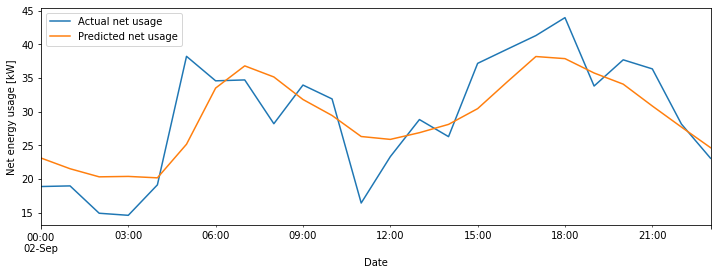

run-uuid: 433c093d654e413386691b5a5b295c3b
Day: 2011-10-20 23:00:00, mae: 7.851, mse: 77.526, rmse: 8.805, r2: -0.992


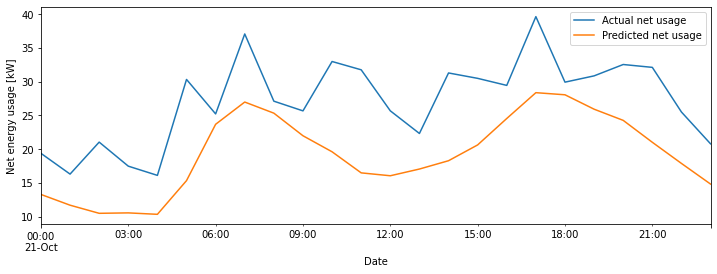

run-uuid: 89d22edf6a284bc5b2f3bc8362877e3e
Day: 2011-01-09 06:00:00, mae: 5.167, mse: 47.476, rmse: 6.890, r2: -0.093


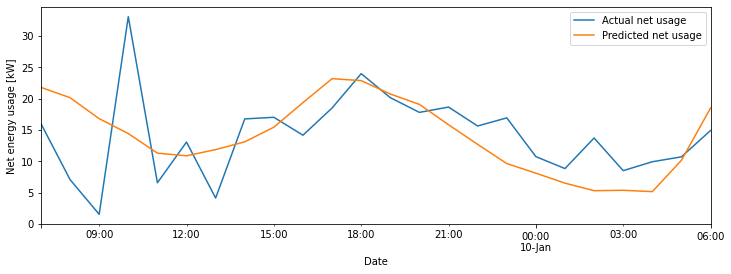

run-uuid: 2f76bc128d11476ea74e0b52daf91f02
Day: 2011-10-22 21:00:00, mae: 6.150, mse: 63.141, rmse: 7.946, r2: 0.147


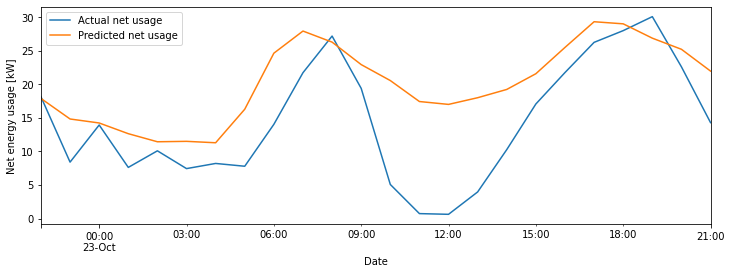

run-uuid: 047108fc5e1d455dbdf49f250830d228
Day: 2011-06-21 03:00:00, mae: 4.934, mse: 46.312, rmse: 6.805, r2: 0.449


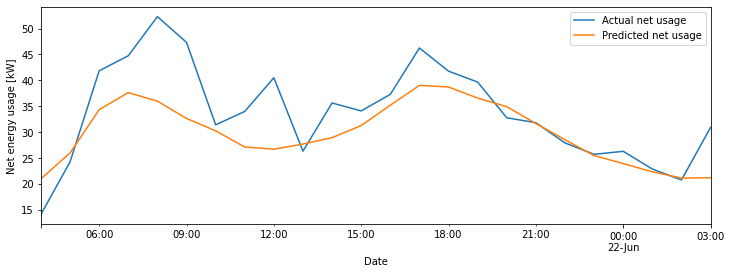

run-uuid: 06859e5c288543f3ab73ae3e187be977
Day: 2011-07-08 02:00:00, mae: 4.417, mse: 26.551, rmse: 5.153, r2: 0.562


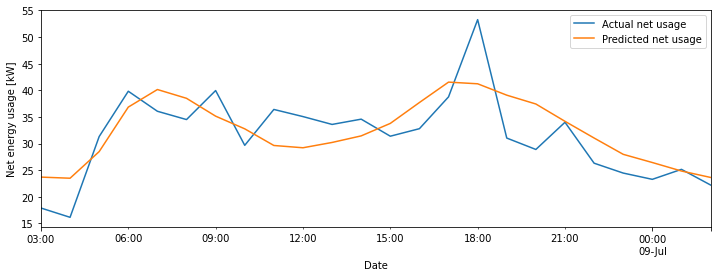

run-uuid: 0af65ed9e0d849b7b79e7eca7f6b3486
Day: 2011-08-19 00:00:00, mae: 5.555, mse: 44.830, rmse: 6.696, r2: 0.347


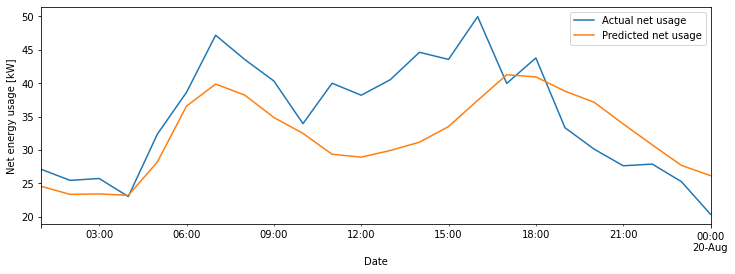

run-uuid: 5a392bbd76e04aa092a78738eb35a307
Day: 2011-04-15 07:00:00, mae: 4.549, mse: 34.102, rmse: 5.840, r2: 0.330


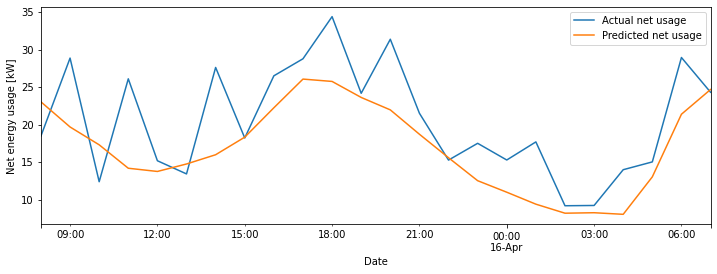

run-uuid: cf48dc1c35c44886a02aa47aa2d264e6


In [9]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)
  start_hour = day + pd.DateOffset(hours=1)
  end_hour = day + pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['linreg_time'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Print error metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
  
  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], 
          df_test['linreg_time'][df_test.index.isin(forecast_hours)])

  if write_data:
    
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="linear_regression_time")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "linear_regression_time")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
# if write_data:
#   forecasts = forecasts.set_index('id')
#   forecasts.to_sql("forecast", con=db, if_exists="append")

### 2. Linear regression model using current weather conditions to predict net energy usage

In [17]:
# Include weather features for linear regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [18]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate r-squared for train data
y_pred_train = lin_reg.predict(X_train)
df_train['linreg'] = y_pred_train

# Calculate r-squared for test data
y_pred_test = lin_reg.predict(X_test)
df_test['linreg'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression")

----------------------------------------
Linear regression
----------------------------------------
R2 (train): 0.745
R2 (test) : 0.705
MAE (test): 4.745
MSE (test): 36.463
RMSE(test): 6.038


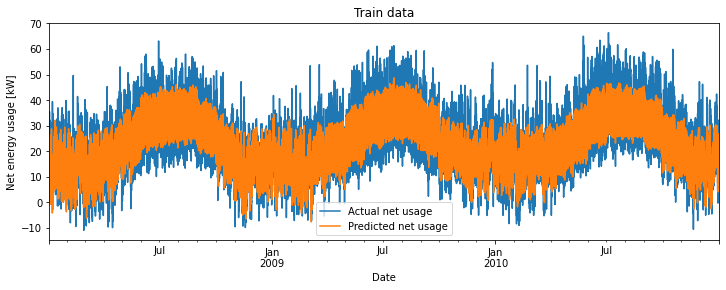

In [64]:
# Plot actual vs predicted train data
plot_ts(df_train['net_load_kW'], df_train['linreg'], "Train data")

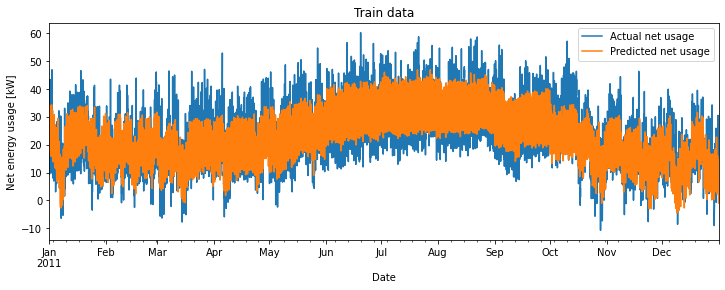

In [44]:
# Plot actual vs predicted train data
plot_ts(df_test['net_load_kW'], df_test['linreg'], "Train data")

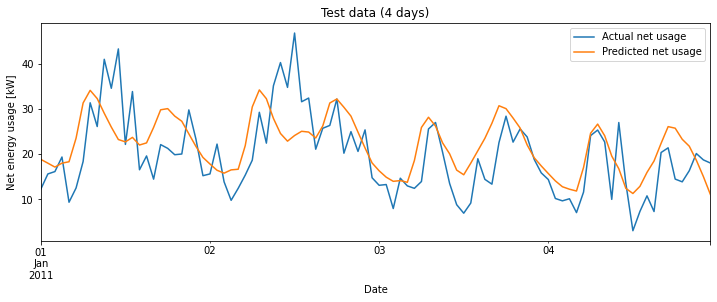

In [45]:
# Plot actual vs predicted train data
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['linreg'].iloc[0:24*4], "Test data (4 days)")

Day: 2011-09-01 23:00:00, mae: 3.791, mse: 22.558, rmse: 4.750, r2: 0.703


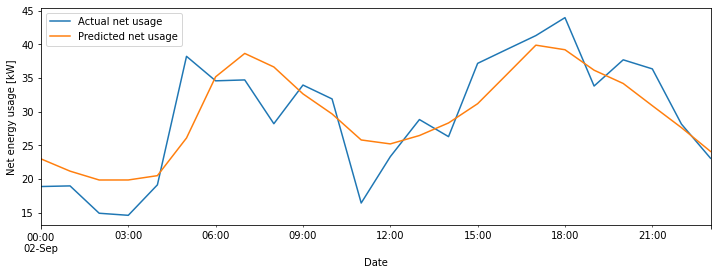

run-uuid: 6596608b85ab45f39ee92d7ef5503f2d
Day: 2011-10-20 23:00:00, mae: 4.081, mse: 24.993, rmse: 4.999, r2: 0.358


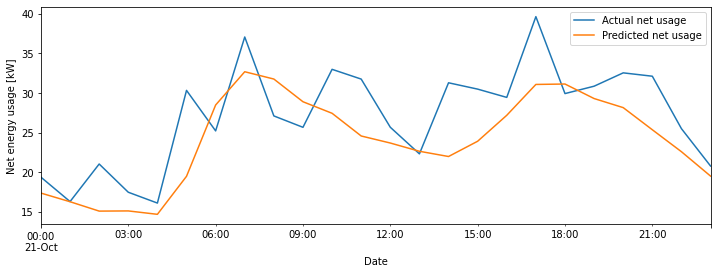

run-uuid: 7e5e5b428e0b40acaa6d8a318ab2f0d4
Day: 2011-01-09 06:00:00, mae: 5.200, mse: 46.744, rmse: 6.837, r2: -0.076


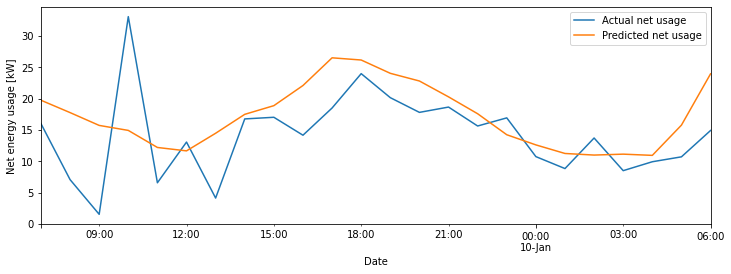

run-uuid: 0c51bbfc206b48e4998d4b20c1729cff
Day: 2011-10-22 21:00:00, mae: 3.778, mse: 22.580, rmse: 4.752, r2: 0.695


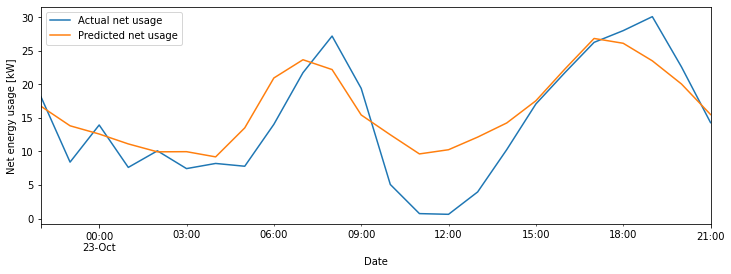

run-uuid: f8da7e7a0658402cb5ff22822d080df2
Day: 2011-06-21 03:00:00, mae: 4.286, mse: 30.005, rmse: 5.478, r2: 0.643


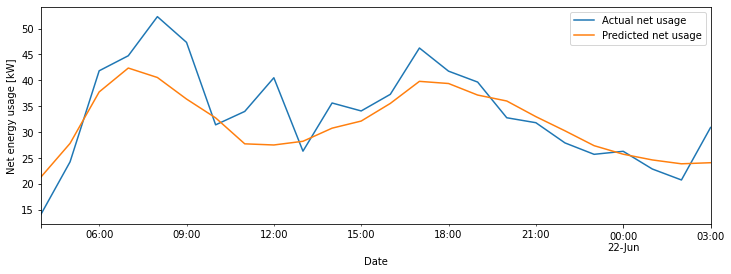

run-uuid: 30cbddf5bbd5470c9426cfd2ea8b8c27
Day: 2011-07-08 02:00:00, mae: 4.261, mse: 26.993, rmse: 5.196, r2: 0.555


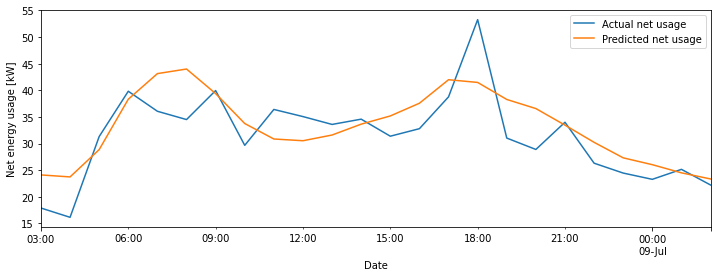

run-uuid: 4d54c722601b490d9dff771a88bb2ee9
Day: 2011-08-19 00:00:00, mae: 4.133, mse: 26.628, rmse: 5.160, r2: 0.612


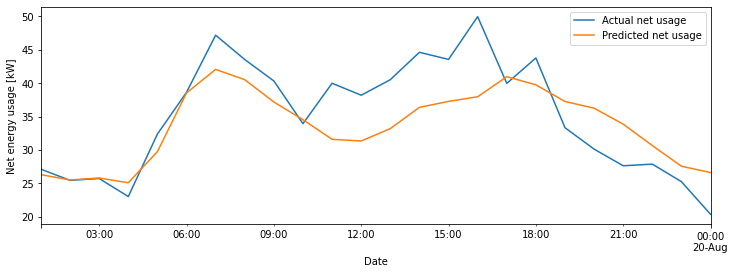

run-uuid: 3bccfe9dd371437c986791e4533b2733
Day: 2011-04-15 07:00:00, mae: 4.123, mse: 26.934, rmse: 5.190, r2: 0.471


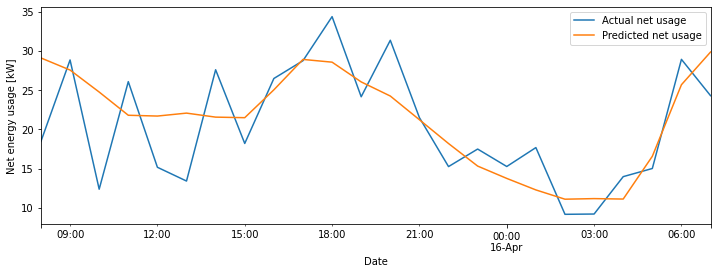

run-uuid: 9d1a762e90cd4ea2a788254b91af7ff9


In [15]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)
  start_hour = day + pd.DateOffset(hours=1)
  end_hour = day + pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['linreg'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Print error metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
  mae_list.append(mae)
  mse_list.append(mse)
  r2_list.append(r2)

  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], 
          df_test['linreg'][df_test.index.isin(forecast_hours)])

  if write_data:
    
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="linear_regression_weather")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "linear_regression_weather")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
  forecasts = forecasts.set_index('id')
  forecasts.to_sql("forecast", con=db, if_exists="append")

In [16]:
print(np.mean(mae_list))
print(np.mean(mse_list))
print(np.mean(np.sqrt(mse_list)))

4.206796974365421
28.429330012643913
5.295098243745035


### 3. Multiple linear regression model with 2 polynomial features using current weather conditions

In [47]:
# Include current weather features for linear regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])
                                                   

In [48]:
# here we will add the second degree polynomial features
n=2
polynomial_features = PolynomialFeatures(degree=n, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train_scaled)   # Transform training data
x_poly_test = polynomial_features.transform(X_test_scaled)         # Transform test data

model_poly = LinearRegression() # Do linear regression
model_poly.fit(x_poly_train, y_train)
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

df_train['linreg_with_poly'] = y_pred_train
df_test['linreg_with_poly'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression with polynomial (n=2)")

----------------------------------------
Linear regression with polynomial (n=2)
----------------------------------------
R2 (train): 0.873
R2 (test) : 0.839
MAE (test): 3.328
MSE (test): 19.945
RMSE(test): 4.466


### Using previously trained model to forecast net energy usage

In [49]:
# Use 24h predicted weather features for linear regression
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 
            'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'workday']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features_fc = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 
                    'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift']
X_train_scaled_fc = X_train
X_test_scaled_fc = X_test
X_train_scaled_fc[scaled_features_fc] = scaler.transform(X_train_scaled_fc[scaled_features_fc])
X_test_scaled_fc[scaled_features_fc] = scaler.transform(X_test_scaled_fc[scaled_features_fc])

In [50]:
# Transform using previous transformation 
x_poly_train_fc = polynomial_features.transform(X_train_scaled_fc) # Transform training x-data
x_poly_test_fc = polynomial_features.transform(X_test_scaled_fc)   # Transform test x-data

# Predict using already trained model
y_pred_train_fc = model_poly.predict(x_poly_train_fc)
y_pred_test_fc = model_poly.predict(x_poly_test_fc)

# Save to DataFrame for plotting
df_train['linreg_poly'] = y_pred_train_fc
df_test['linreg_poly'] = y_pred_test_fc

# Print error metrics
_ = error_metrics(y_train, y_pred_train_fc, y_test, y_pred_test_fc, title="Linear regression with polynomial features using 24h weather forecasts")

----------------------------------------
Linear regression with polynomial features using 24h weather forecasts
----------------------------------------
R2 (train): 0.863
R2 (test) : 0.829
MAE (test): 3.457
MSE (test): 21.148
RMSE(test): 4.599


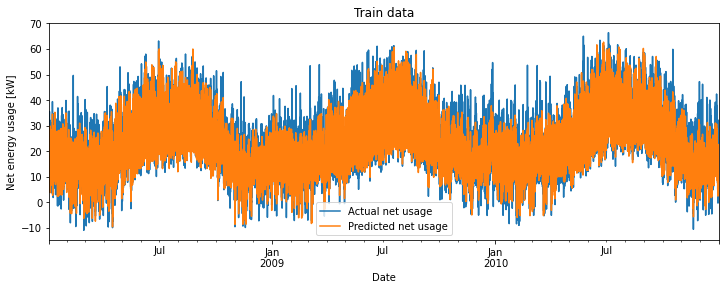

In [51]:
# Plot actual vs predicted train data
plot_ts(df_train['net_load_kW'], df_train['linreg_poly'], "Train data")

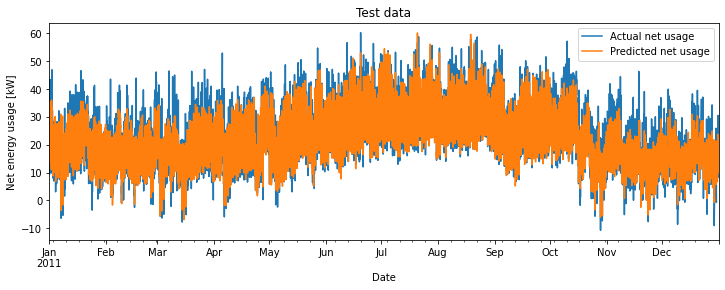

In [52]:
# Plot actual vs predicted test data
plot_ts(df_test['net_load_kW'], df_test['linreg_poly'], "Test data")

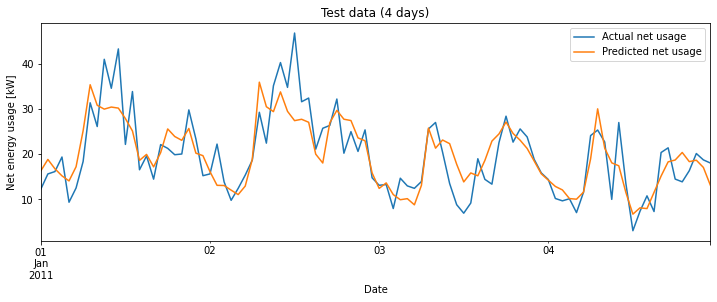

In [53]:
# Plot actual vs predicted test data for 4 days
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['linreg_poly'].iloc[0:24*4], "Test data (4 days)")

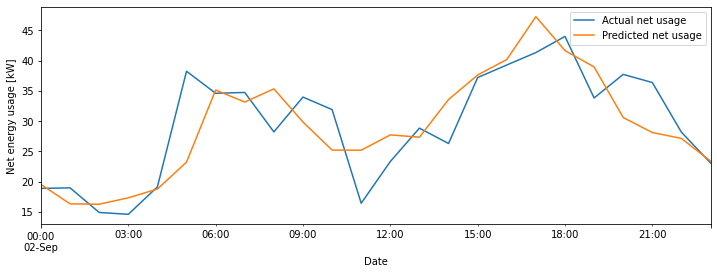

Mean Absolute Error (Linear regression) = 4.005
Mean Squared Error (Linear regression) = 29.001
Root Mean Squared Error (Linear regression) = 5.385
R2 score (Linear regression) = 0.618
---------------------------------------------


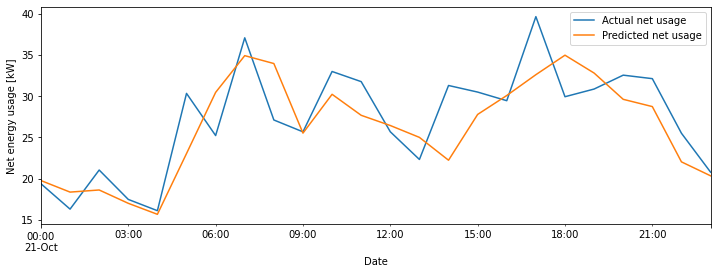

Mean Absolute Error (Linear regression) = 3.1
Mean Squared Error (Linear regression) = 15.65
Root Mean Squared Error (Linear regression) = 3.956
R2 score (Linear regression) = 0.598
---------------------------------------------


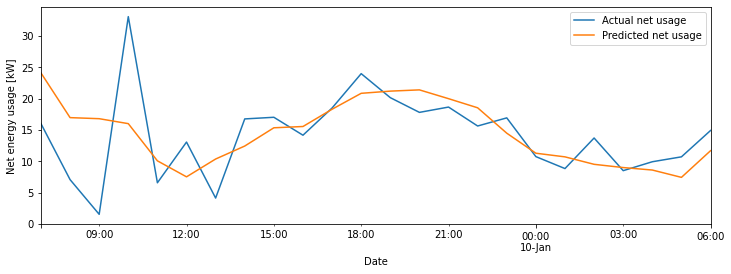

Mean Absolute Error (Linear regression) = 4.275
Mean Squared Error (Linear regression) = 36.582
Root Mean Squared Error (Linear regression) = 6.048
R2 score (Linear regression) = 0.158
---------------------------------------------


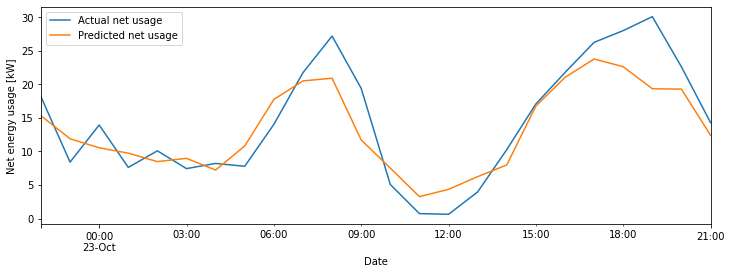

Mean Absolute Error (Linear regression) = 3.163
Mean Squared Error (Linear regression) = 15.284
Root Mean Squared Error (Linear regression) = 3.909
R2 score (Linear regression) = 0.793
---------------------------------------------


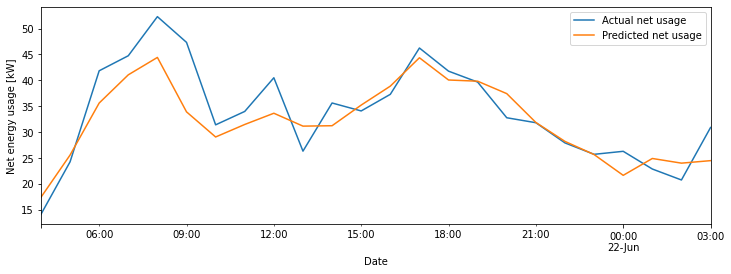

Mean Absolute Error (Linear regression) = 3.521
Mean Squared Error (Linear regression) = 21.533
Root Mean Squared Error (Linear regression) = 4.64
R2 score (Linear regression) = 0.744
---------------------------------------------


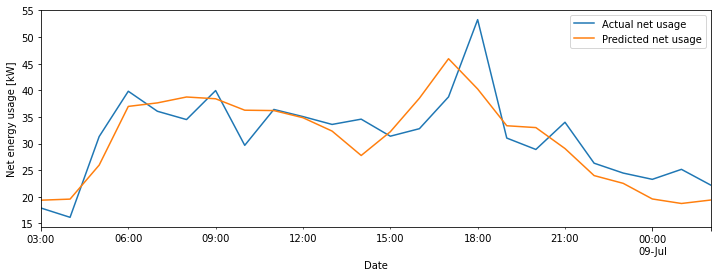

Mean Absolute Error (Linear regression) = 3.78
Mean Squared Error (Linear regression) = 22.368
Root Mean Squared Error (Linear regression) = 4.729
R2 score (Linear regression) = 0.631
---------------------------------------------


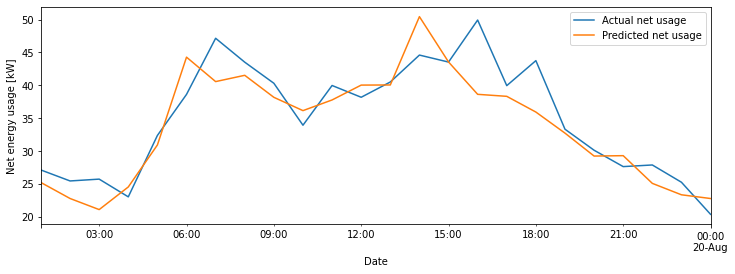

Mean Absolute Error (Linear regression) = 3.006
Mean Squared Error (Linear regression) = 15.875
Root Mean Squared Error (Linear regression) = 3.984
R2 score (Linear regression) = 0.769
---------------------------------------------


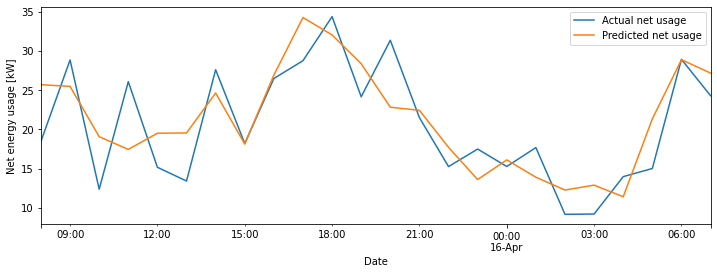

Mean Absolute Error (Linear regression) = 3.791
Mean Squared Error (Linear regression) = 20.422
Root Mean Squared Error (Linear regression) = 4.519
R2 score (Linear regression) = 0.599
---------------------------------------------


In [54]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)

  start_hour = day + pd.DateOffset(hours=1)
  end_hour = day + pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['linreg_poly'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], df_test['linreg_poly'][df_test.index.isin(forecast_hours)])

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Mean Absolute Error (Linear regression) = {mae.round(3)}")
  print(f"Mean Squared Error (Linear regression) = {mse.round(3)}")
  print(f"Root Mean Squared Error (Linear regression) = {np.sqrt(mse).round(3)}")
  print(f"R2 score (Linear regression) = {r2.round(3)}")
  print("---------------------------------------------")

  mae_list.append(mae)
  mse_list.append(mse)
  r2_list.append(r2)

  if write_data:
    
    # ##########
    # # MLFLOW #
    # ##########
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="poly_regression")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "poly_regression")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
  forecasts = forecasts.set_index('id')
  forecasts.to_sql("forecast", con=db, if_exists="append")
  

In [55]:
print(np.mean(mae_list))
print(np.mean(mse_list))
print(np.mean(np.sqrt(mse_list)))

3.580033935546875
22.089258179309212
4.646523286708435


## Feature engineering

Instead of treating each hour and each month as individual category, we group them since certain hours of the day should have similar energy usage patterns.

In [56]:
# Group months into seasons
def seasons(x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'autumn'

# Group hours into morning, afternoon, evening or night
def time_of_day(x):
    if x in [7, 8, 9, 10, 11]:
        return 'morning'
    elif x in [12, 13, 14, 15, 16]:
        return 'afternoon'
    elif x in [17, 18, 19, 20, 21]:
        return 'evening'
    elif x in [22, 23, 0, 1, 2, 3, 4, 5, 6]:
        return 'night'        

In [57]:
df['season'] = df['month'].apply(seasons)
df['season'] = df['season'].astype('category')

df['time_of_day'] = df['hour'].apply(time_of_day)
df['time_of_day'] = df['time_of_day'].astype('category')

df['day_of_week'] = df.index.day_of_week

In [58]:
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

# Define features and target variables
features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'season', 'time_of_day', 'holiday', 'day_of_week']
target = 'net_load_kW'

X = df[features]
y = df[target]

X['season'] = X['season'].astype('category')
X['time_of_day'] = X['time_of_day'].astype('category')
X['holiday'] = X['holiday'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')
X = pd.get_dummies(X, drop_first=True)

# Train and test split 
# First 3 years is the training data
X_train = X[:(len(X)-365*24)]
y_train = y[:(len(y)-365*24)]

# Last year is the test data
X_test = X[(len(X)-365*24):]
y_test = y[(len(y)-365*24):]

# Scaling features
cols_to_scale = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [59]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate r-squared for train data
y_pred_train = lin_reg.predict(X_train)
df_train['net_load_kW_lin_forecast'] = y_pred_train

# Calculate r-squared for test data
y_pred_test = lin_reg.predict(X_test)
df_test['net_load_kW_lin_forecast'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Linear regression with feature engineering")

----------------------------------------
Linear regression with feature engineering
----------------------------------------
R2 (train): 0.621
R2 (test) : 0.592
MAE (test): 5.532
MSE (test): 50.494
RMSE(test): 7.106


In [60]:
# here we will add the second degree polynomial features
n = 2
polynomial_features = PolynomialFeatures(degree=n, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train_scaled)   # Transform training x-data
x_poly_test = polynomial_features.transform(X_test_scaled)         # Transform test x-data

model_poly = LinearRegression() # Do linear regression
model_poly.fit(x_poly_train, y_train)
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

df_train['net_load_kW_poly_forecast'] = y_pred_train
df_test['net_load_kW_poly_forecast'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Polynomial linear regression with feature engineering")

----------------------------------------
Polynomial linear regression with feature engineering
----------------------------------------
R2 (train): 0.828
R2 (test) : 0.791
MAE (test): 3.845
MSE (test): 25.826
RMSE(test): 5.082


Putting the hours of the day and the months of the year into categories does not seem to offer any significant improvement to the net energy usage forecasts.